In [1]:
import glob
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import gc
import os
import argparse
import warnings
import tqdm

import splot
import geopandas as gpd
from sklearn.metrics.pairwise import cosine_similarity
from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from scipy.sparse import issparse
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, spearmanr
from skimage.metrics import structural_similarity as ssim

# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset_name', type=str, default="SCC_Chenhao", help='Dataset choice.')
# parser.add_argument('--fold', type=int, default=0, help='No. of slides')
# parser.add_argument('--augment', type=str, default="blur", help='augmentation choice.')
# parser.add_argument('--exp_norm', type=str, default="log1p", help='expression normalization choice.')

# args = parser.parse_args()

def get_R(data1,data2, dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[1]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_MI(adata1, adata2, gene_list, spatial_matrix):
    moran_scores = []
    adata1.obsm["gpd"] = gpd.GeoDataFrame(adata1.obs, geometry=gpd.points_from_xy(spatial_matrix[:, 0], spatial_matrix[:, 1]))
    print("Calculate Moran's I score...")
    for gene in tqdm.tqdm(gene_list):
        x = adata1.to_df()[gene].values
        y = adata2.to_df()[gene].values
        w = Queen.from_dataframe(adata1.obsm["gpd"])
        moran_bv = Moran_BV(y, x, w)
        moran_scores.append(moran_bv.I)
    return moran_scores

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

def top_predictable_genes(df_all, dataset, method, num=5,):
    """
    input the results from the make_res function.
    output the top predictable genes with the number of positive Pearson correlation values.
    num is the number of top predictable genes.
    """
    df = df_all[df_all["Method"]==method]
    if num == "pos":
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)
    top5_genes = list(top5_df.index)
    
    # Subset the results according to top predictable gene
    num_pos = []
    for g in top5_genes:
        subset_df = df[df["Gene"]==g]
        count_positive_corr = subset_df[subset_df['Pearson correlation'] > 0].shape[0]
        # print(f'Number of positive Pearson correlation values: {count_positive_corr}')
        num_pos.append(int(count_positive_corr))
    top5_df["Number of consistent samples"] = num_pos
    top5_df["Method"] = method
    top5_df["Dataset"] = dataset
    top5_df = top5_df[[(           'Method',       ''),
            (                     'Dataset',       ''),
            ('Number of consistent samples',       ''),
            (         'Pearson correlation',   'mean'),
            (         'Pearson correlation', 'median'),
            (         'Pearson correlation', 'min'),
            (         'Pearson correlation',    'max'),
            (         'Pearson correlation',    'std'),
            
            ]]

    return top5_df


def make_res(fold, augment, exp_norm, names):
    """
    input the dataset name, colornorm, methods, and names of the slides
    output the results of the methods with three metrics: Pearson correlation, Spearman correlation, and SSIM score
    """
    gc.collect()
    name = names[fold]
    file_path = f"../Results/preprocessing/pred_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad"
    if os.path.exists(file_path):
        data1 = sc.read_h5ad(f"../Results/preprocessing/pred_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad")
        data2 = sc.read_h5ad(f"../Results/preprocessing/gt_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad")
        # spatial_matrix = np.load(f"../Results/preprocessing/spatial_loc_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.npy")
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        cosine_score = get_cosine(data1, data2)
        data1.var_names = data2.var_names
        # MI = get_MI(data1, data2, list(data1.var_names), spatial_matrix)
        PCC_BC_Visium = {
        "Gene": list(data1.var_names),
        "Pearson correlation": pcc,
        "PCC_PValue": PCC_PValue,
        "Spearmanr correlation": SPC,
        "SPC_PValue": SPC_PValue,
        "SSIM_Score": ssim_score,
        "Cosine_Score": cosine_score,
        # "Moran'I_Score": MI,
        "Slides": [name]*len(pcc),
        "Image_transformation": [augment]*len(pcc),
        "Expression_normalization": [exp_norm]*len(pcc),}
        
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
        if not os.path.isdir(f"../Results/preprocessing"):
            os.mkdir(f"../Results/preprocessing")
        PCC_BC_Visium.to_csv(f"../Results/preprocessing/deeppt_{augment}_{exp_norm}_raw_{name}_hvg.csv")
    else:
        print(f"The file {file_path} does not exist. Skipping.")
    print("Organize the results into summary file!")
    res = glob.glob(f"../Results/preprocessing/*_hvg.csv")
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])
    df.reset_index(inplace=True)
    df.to_csv(f"../Results/Summary/preprocessing_summary_hvg.csv")
    return df


/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_5719/708917586.py:13: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEO

In [30]:
# Read the method names
names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
names.sort()

# # Benchmarking augmentation methods
# for augment in ["reinhard", "blur", "random_grayscale", "random_rotation", "none"]: 
#     for fold in range(12):
#         exp_norm = "log1p"
#         print(f"Sample names:{names}")
#         print(f"Sample name:{names[fold]}")
#         print(f"fold:{fold}")
#         print(f"augment:{augment}")
#         print(f"exp_norm:{exp_norm}")

#         # Organize the results into dataframe
#         df = make_res(fold, augment, exp_norm, names)

# Benchmarking expression normalization methods
for exp_norm in ["norm"]: # "raw", "log1p", "lognorm", "minmax", 
    for fold in range(12):
        augment = "none"
        print(f"Sample names:{names}")
        print(f"Sample name:{names[fold]}")
        print(f"fold:{fold}")
        print(f"augment:{augment}")
        print(f"exp_norm:{exp_norm}")

        # Organize the results into dataframe
        df = make_res(fold, augment, exp_norm, names)

Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3']
Sample name:P10_ST_rep1
fold:0
augment:none
exp_norm:norm
Organize the results into summary file!
Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3']
Sample name:P10_ST_rep2
fold:1
augment:none
exp_norm:norm
Organize the results into summary file!
Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3']
Sample name:P10_ST_rep3
fold:2
augment:none
exp_norm:norm
Organize the results into summary file!
Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_r

In [58]:
name = "P10_ST_rep1"
augment = "none"
exp_norm = "norm"
adata1 = sc.read_h5ad(f"../Results/preprocessing/pred_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad")
adata2 = sc.read_h5ad(f"../Results/preprocessing/gt_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad")


In [59]:
adata1.to_df()

,PPP1R12A,S100P,IMP4,KRT2,SOX4,SAMD4B,SPPL2A,RALBP1,RAB3GAP2,TNRC6A,...,PTHLH,NF1,TIMP3,NHP2,ZBTB7A,DDX18,FLG,NEMF,DYNC1I2,KCTD1
0,42.243587,22.172234,17.104128,18.419159,84.246666,15.048264,24.814342,51.137943,16.866629,41.293510,...,40.741016,13.156658,33.514858,24.658514,72.414223,45.576149,78.514626,31.513355,87.154488,20.470484
1,36.654049,14.695337,15.850131,181.901215,57.426777,9.771666,17.132004,41.764744,16.257898,28.430876,...,34.526630,13.256636,32.821781,38.335659,56.311024,38.207458,64.781532,27.777149,66.986633,16.403212
2,42.331024,19.062744,11.161549,324.321350,61.015251,10.481627,14.880901,44.630322,16.324390,30.301586,...,28.133045,13.386012,28.708479,29.031712,58.277870,38.774605,133.495178,21.709826,65.097748,19.565958
3,51.211056,31.732594,12.765254,-52.836128,85.204842,16.253069,25.915760,57.608925,18.231642,42.346153,...,37.725075,18.222898,32.166313,21.205639,86.241837,42.663689,56.223625,32.739967,87.559494,20.294731
4,42.433895,23.050610,21.328657,187.261749,81.722435,12.241745,23.385456,53.796768,17.507774,35.396156,...,32.869694,17.789431,28.857670,42.988388,70.639015,42.009975,61.683578,35.169456,80.842194,24.452269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,41.392864,13.493924,19.487684,336.456879,75.595482,14.531847,19.708305,47.501869,16.897959,35.816166,...,41.951839,16.319429,27.010727,37.217640,76.545921,42.248318,50.514702,32.141182,79.849442,23.502602
596,42.967167,22.159237,17.512379,125.793365,78.298584,15.330618,24.447521,50.510166,16.574533,32.691368,...,39.458504,12.938289,29.033573,34.921703,72.921112,47.627411,32.379719,31.138371,86.123230,24.499535
597,20.619665,28.899105,13.629638,-129.144669,58.056099,7.786529,16.609919,35.303539,12.089669,21.309454,...,17.964506,12.907369,10.519003,21.151211,49.988274,23.204489,-2.060097,21.123344,46.823238,17.497993
598,43.764709,15.206124,18.381651,160.886841,69.059494,18.265919,19.588268,52.422970,15.355147,36.980927,...,31.297096,15.657966,40.362633,42.552883,73.779335,44.438614,147.713043,32.689617,75.881058,23.382969


In [60]:
adata2.to_df()

,PPP1R12A,S100P,IMP4,KRT2,SOX4,SAMD4B,SPPL2A,RALBP1,RAB3GAP2,TNRC6A,...,PTHLH,NF1,TIMP3,NHP2,ZBTB7A,DDX18,FLG,NEMF,DYNC1I2,KCTD1
37x21,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,285.714294,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,285.714294,0.000000,0.000000,0.000000
36x50,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,666.666687,0.000000,0.000000,0.000000
22x38,0.000000,0.000000,0.000000,0.000000,454.545441,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,454.545441,0.0,0.000000,0.000000,0.000000,0.000000
27x19,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,2000.000000,0.000000,666.666687,0.000000
25x45,0.000000,0.000000,0.000000,263.157898,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,263.157898,0.0,0.000000,0.000000,526.315796,263.157898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19x41,0.000000,95.238098,0.000000,0.000000,0.000000,0.0,0.000000,95.238098,0.000000,95.238098,...,0.0,0.0,0.0,0.0,0.000000,0.0,95.238098,190.476196,0.000000,95.238098
38x42,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
35x23,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,270.270264,0.000000,540.540527,0.000000
17x33,163.934433,163.934433,0.000000,0.000000,163.934433,0.0,0.000000,163.934433,0.000000,163.934433,...,0.0,0.0,0.0,0.0,0.000000,0.0,819.672119,0.000000,327.868866,0.000000


In [31]:
df = pd.read_csv(f"../Results/Summary/preprocessing_summary_hvg.csv")
df


,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Image_transformation,Expression_normalization
0,0,0,PPP1R12A,0.240466,9.265636e-17,0.200161,4.554359e-12,0.189147,0.479845,P9_ST_rep1,random_grayscale,log1p
1,1,1,S100P,0.280864,2.063285e-22,0.232428,9.465172e-16,0.225798,0.514861,P9_ST_rep1,random_grayscale,log1p
2,2,2,IMP4,0.395407,2.890230e-44,0.263526,7.258786e-20,0.209619,0.460858,P9_ST_rep1,random_grayscale,log1p
3,3,3,KRT2,0.247737,1.050628e-17,0.110900,8.774930e-05,0.060471,0.361859,P9_ST_rep1,random_grayscale,log1p
4,4,4,SOX4,0.317998,1.669502e-28,0.267120,2.229341e-20,0.255756,0.609828,P9_ST_rep1,random_grayscale,log1p
...,...,...,...,...,...,...,...,...,...,...,...,...
18463,18463,166,DDX18,0.030272,2.475793e-01,0.025408,2.834997e-01,0.025094,0.348285,P5_ST_rep2,none,log1p
18464,18464,167,FLG,0.264281,6.731541e-10,0.183254,1.566273e-05,0.256717,0.713180,P5_ST_rep2,none,log1p
18465,18465,168,NEMF,0.105832,8.404054e-03,0.103306,9.811172e-03,0.062585,0.419995,P5_ST_rep2,none,log1p
18466,18466,169,DYNC1I2,0.045554,1.522678e-01,0.065357,7.025119e-02,0.039469,0.512284,P5_ST_rep2,none,log1p


In [32]:
expression_norm = df[df["Image_transformation"]=="none"]

In [33]:
expression_norm.groupby(["Expression_normalization"]).agg({"Pearson correlation": ["median", "mean", "min", "max", "std"]}).sort_values(by=("Pearson correlation", "median"), ascending=False).sort_index(level=0)


Pearson correlation                                \
                                      median      mean       min       max   
Expression_normalization                                                     
log1p                               0.290160  0.314486 -0.058683  0.834745   
lognorm                             0.135521  0.152008 -0.091265  0.508891   
minmax                              0.239239  0.259724 -0.086160  0.770727   
norm                                0.029039  0.047485 -0.329029  0.668265   
raw                                 0.266810  0.288692 -0.142049  0.867050   

                                    
                               std  
Expression_normalization            
log1p                     0.199340  
lognorm                   0.107688  
minmax                    0.184986  
norm                      0.097868  
raw                       0.190114

In [71]:
img_trans = df[df["Image_transformation"]!="none"]
baseline = df[(df["Image_transformation"]=="none") & (df["Expression_normalization"]=="log1p")]
img_trans = pd.concat([img_trans, baseline])

In [72]:
img_trans.groupby(["Image_transformation"]).agg({"Pearson correlation": ["median", "mean", "min", "max", "std"]}).sort_values(by=("Pearson correlation", "median"), ascending=False).sort_index(level=0)


Pearson correlation                                \
                                  median      mean       min       max   
Image_transformation                                                     
blur                            0.306971  0.313713 -0.099798  0.841669   
none                            0.290160  0.314486 -0.058683  0.834745   
random_grayscale                0.316890  0.317913 -0.111005  0.847523   
random_rotation                 0.319598  0.327690 -0.102043  0.839881   
reinhard                        0.301277  0.323224 -0.105180  0.859490   

                                
                           std  
Image_transformation            
blur                  0.191716  
none                  0.199340  
random_grayscale      0.204922  
random_rotation       0.196669  
reinhard              0.200176

In [73]:
method_mapping = {
    'random_grayscale': "Random grayscale",
    'none': "Without augmentation",
    'blur': "Gaussian blur",
    'random_rotation': "Random rotation",
    'reinhard': "Reinhard color normalization",
}

# Replace model and dataset names in the DataFrame
img_trans.replace({'Image_transformation': method_mapping}, inplace=True)

# Define the order for Dataset and Method columns
method_order = ['Without augmentation', 'Random grayscale', 'Reinhard color normalization', 'Gaussian blur', 'Random rotation']

# Use pd.Categorical directly during DataFrame creation
img_trans['Image_transformation'] = pd.Categorical(img_trans['Image_transformation'], categories=method_order, ordered=True)

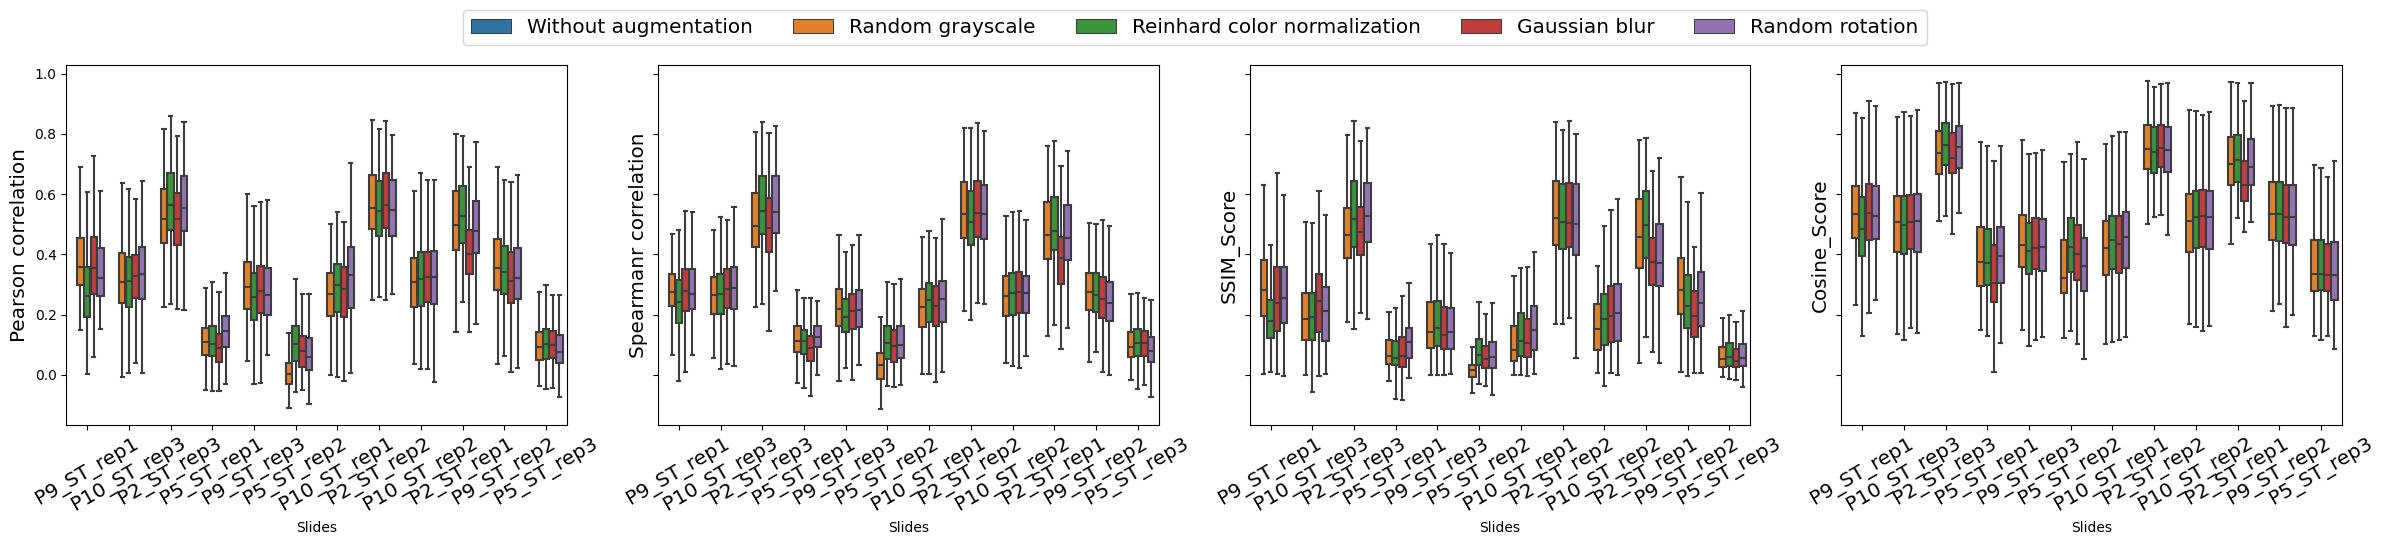

192673

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Assuming img_trans is your DataFrame

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

# Plot the first boxplot
sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="Pearson correlation", showfliers=False, ax=axes[0])
axes[0].get_legend().remove()
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
axes[0].set_ylabel("Pearson correlation", fontsize='x-large')  # Set y-axis label

# Plot the second boxplot
sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="Spearmanr correlation", showfliers=False, ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
axes[1].set_ylabel("Spearmanr correlation", fontsize='x-large')  # Set y-axis label

# Plot the third boxplot (I assume this is supposed to be a different metric, change as needed)
sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="SSIM_Score", showfliers=False, ax=axes[2])
axes[2].get_legend().remove()
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
axes[2].set_ylabel("SSIM_Score", fontsize='x-large')  # Set y-axis label

# Plot the fourth boxplot
sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="Cosine_Score", showfliers=False, ax=axes[3])
axes[3].get_legend().remove()
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
axes[3].set_ylabel("Cosine_Score", fontsize='x-large')  # Set y-axis label

# Adjust title fontsize
for ax in axes:
    ax.title.set_fontsize('x-large')

# Adjust legend fontsize
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='x-large')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
gc.collect()


In [74]:
img_trans

,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Image_transformation,Expression_normalization
0,0,0,PPP1R12A,0.240466,9.265636e-17,0.200161,4.554359e-12,0.189147,0.479845,P9_ST_rep1,Random grayscale,log1p
1,1,1,S100P,0.280864,2.063285e-22,0.232428,9.465172e-16,0.225798,0.514861,P9_ST_rep1,Random grayscale,log1p
2,2,2,IMP4,0.395407,2.890230e-44,0.263526,7.258786e-20,0.209619,0.460858,P9_ST_rep1,Random grayscale,log1p
3,3,3,KRT2,0.247737,1.050628e-17,0.110900,8.774930e-05,0.060471,0.361859,P9_ST_rep1,Random grayscale,log1p
4,4,4,SOX4,0.317998,1.669502e-28,0.267120,2.229341e-20,0.255756,0.609828,P9_ST_rep1,Random grayscale,log1p
...,...,...,...,...,...,...,...,...,...,...,...,...
18463,18463,166,DDX18,0.030272,2.475793e-01,0.025408,2.834997e-01,0.025094,0.348285,P5_ST_rep2,Without augmentation,log1p
18464,18464,167,FLG,0.264281,6.731541e-10,0.183254,1.566273e-05,0.256717,0.713180,P5_ST_rep2,Without augmentation,log1p
18465,18465,168,NEMF,0.105832,8.404054e-03,0.103306,9.811172e-03,0.062585,0.419995,P5_ST_rep2,Without augmentation,log1p
18466,18466,169,DYNC1I2,0.045554,1.522678e-01,0.065357,7.025119e-02,0.039469,0.512284,P5_ST_rep2,Without augmentation,log1p


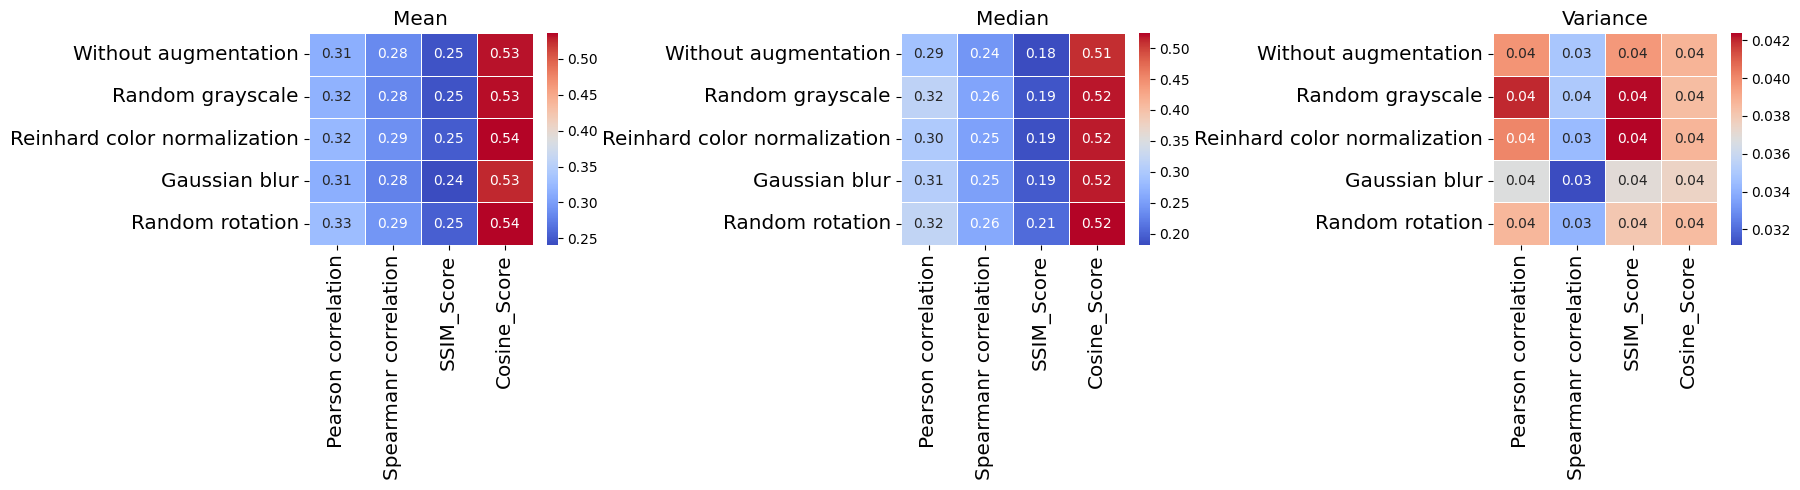

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming expression_norm is your DataFrame

# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean heatmap
grouped_data_mean = img_trans.groupby('Image_transformation').agg({
    'Pearson correlation': 'mean',
    'Spearmanr correlation': 'mean',
    'SSIM_Score': 'mean',
    'Cosine_Score': 'mean',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_mean[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title("Mean", fontsize='x-large')
axes[0].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Median heatmap
grouped_data_median = img_trans.groupby('Image_transformation').agg({
    'Pearson correlation': 'median',
    'Spearmanr correlation': 'median',
    'SSIM_Score': 'median',
    'Cosine_Score': 'median',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_median[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title("Median", fontsize='x-large')
axes[1].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Variance heatmap
grouped_data_var = img_trans.groupby('Image_transformation').agg({
    'Pearson correlation': 'var',
    'Spearmanr correlation': 'var',
    'SSIM_Score': 'var',
    'Cosine_Score': 'var',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_var[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[2])
axes[2].set_title("Variance", fontsize='x-large')
axes[2].set_ylabel("", fontsize='xx-large')  # Set y-axis label
axes[2].set_xticklabels(axes[2].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
expression_norm

,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Image_transformation,Expression_normalization
171,171,0,PPP1R12A,0.136770,1.330830e-06,0.130611,3.696847e-06,0.083361,0.347668,P9_ST_rep3,none,minmax
172,172,1,S100P,0.161722,1.329714e-08,0.170366,2.257784e-09,0.080426,0.327878,P9_ST_rep3,none,minmax
173,173,2,IMP4,0.266289,9.613277e-21,0.229346,9.903949e-16,0.089320,0.318285,P9_ST_rep3,none,minmax
174,174,3,KRT2,0.264593,1.702812e-20,0.190182,2.722868e-11,0.060721,0.284141,P9_ST_rep3,none,minmax
175,175,4,SOX4,0.223455,5.246218e-15,0.171109,1.930066e-09,0.120870,0.440874,P9_ST_rep3,none,minmax
...,...,...,...,...,...,...,...,...,...,...,...,...
16411,16411,166,DDX18,0.030272,2.475793e-01,0.025408,2.834997e-01,0.025094,0.348285,P5_ST_rep2,none,log1p
16412,16412,167,FLG,0.264281,6.731541e-10,0.183254,1.566273e-05,0.256717,0.713180,P5_ST_rep2,none,log1p
16413,16413,168,NEMF,0.105832,8.404054e-03,0.103306,9.811172e-03,0.062585,0.419995,P5_ST_rep2,none,log1p
16414,16414,169,DYNC1I2,0.045554,1.522678e-01,0.065357,7.025119e-02,0.039469,0.512284,P5_ST_rep2,none,log1p


In [40]:
method_mapping = {
    'log1p': "Log transformation",
    'minmax': "Minmax scaling",
    'lognorm': "Log transformation + Normalization",
    'norm': "Normalization",
    'raw': "Without preprocessing"
}

# Replace model and dataset names in the DataFrame
expression_norm.replace({'Expression_normalization': method_mapping}, inplace=True)

# Define the order for Dataset and Method columns
method_order = ['Without preprocessing', 'Normalization', 'Minmax scaling', 'Log transformation', 'Log transformation + Normalization', ]
slides_order = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']

# Use pd.Categorical directly during DataFrame creation
expression_norm['Expression_normalization'] = pd.Categorical(expression_norm['Expression_normalization'], categories=method_order, ordered=True)
expression_norm['Slides'] = pd.Categorical(expression_norm['Slides'], categories=slides_order, ordered=True)


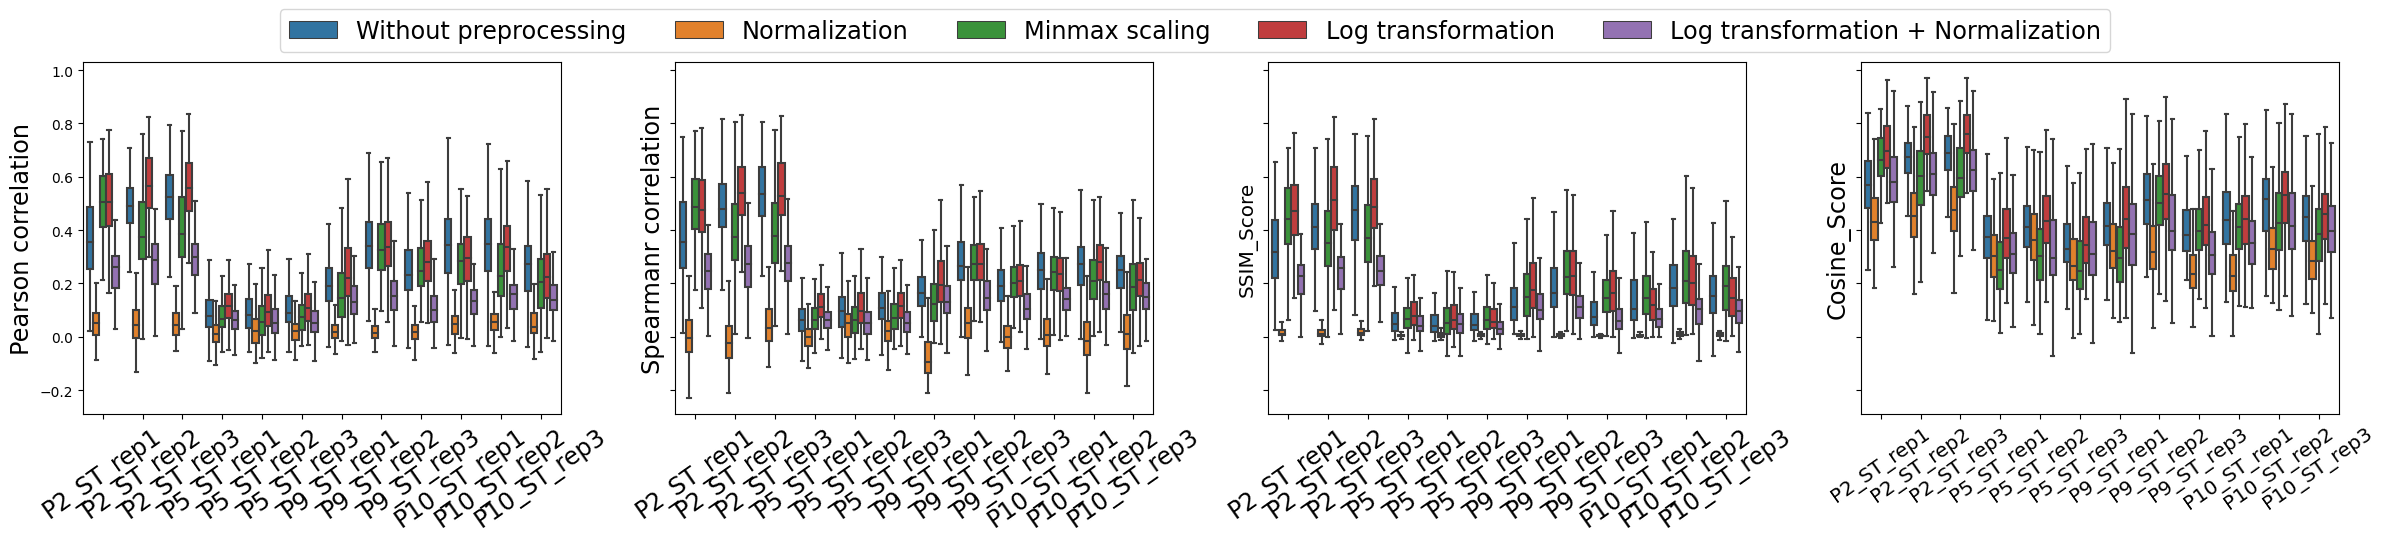

116891

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Assuming img_trans is your DataFrame

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

# Plot the first boxplot
sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="Pearson correlation", showfliers=False, ax=axes[0])
axes[0].get_legend().remove()
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=35, fontsize='xx-large')  # Rotate x-axis labels
axes[0].set_ylabel("Pearson correlation", fontsize='xx-large')  # Set y-axis label
axes[0].set_xlabel("", fontsize='xx-large')  # Set y-axis label

# Plot the second boxplot
sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="Spearmanr correlation", showfliers=False, ax=axes[1])
axes[1].get_legend().remove()
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=35, fontsize='xx-large')  # Rotate x-axis labels
axes[1].set_ylabel("Spearmanr correlation", fontsize='xx-large')  # Set y-axis label
axes[1].set_xlabel("", fontsize='xx-large')  # Set y-axis label

# Plot the third boxplot (I assume this is supposed to be a different metric, change as needed)
sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="SSIM_Score", showfliers=False, ax=axes[2])
axes[2].get_legend().remove()
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=35, fontsize='xx-large')  # Rotate x-axis labels
axes[2].set_ylabel("SSIM_Score", fontsize='x-large')  # Set y-axis label
axes[2].set_xlabel("", fontsize='xx-large')  # Set y-axis label


# Plot the fourth boxplot
sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="Cosine_Score", showfliers=False, ax=axes[3])
axes[3].get_legend().remove()
axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=35, fontsize='x-large')  # Rotate x-axis labels
axes[3].set_ylabel("Cosine_Score", fontsize='xx-large')  # Set y-axis label
axes[3].set_xlabel("", fontsize='xx-large')  # Set y-axis label


# Adjust title fontsize
for ax in axes:
    ax.title.set_fontsize('xx-large')

# Adjust legend fontsize
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='xx-large')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
gc.collect()


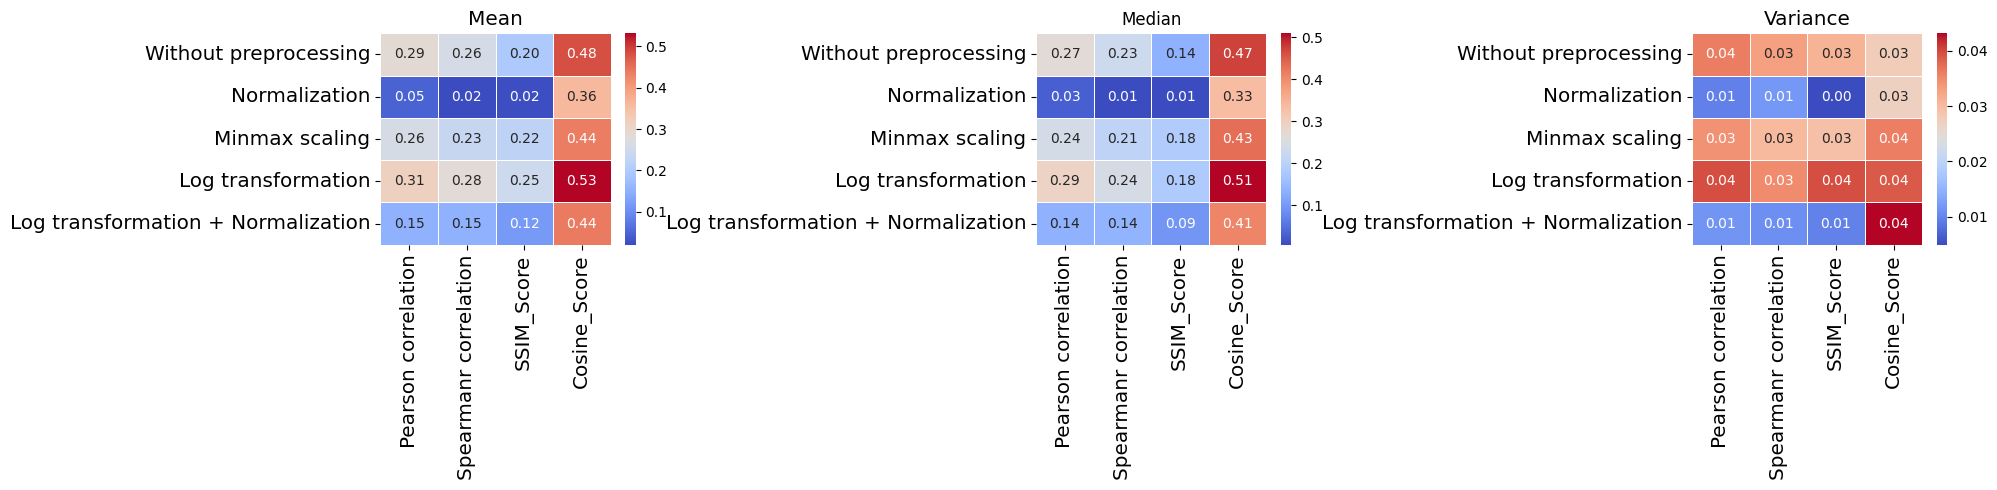

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming expression_norm is your DataFrame

# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Mean heatmap
grouped_data_mean = expression_norm.groupby('Expression_normalization').agg({
    'Pearson correlation': 'mean',
    'Spearmanr correlation': 'mean',
    'SSIM_Score': 'mean',
    'Cosine_Score': 'mean',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_mean[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title("Mean", fontsize='x-large')
axes[0].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Median heatmap
grouped_data_median = expression_norm.groupby('Expression_normalization').agg({
    'Pearson correlation': 'median',
    'Spearmanr correlation': 'median',
    'SSIM_Score': 'median',
    'Cosine_Score': 'median',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_median[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title("Median")
axes[1].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Variance heatmap
grouped_data_var = expression_norm.groupby('Expression_normalization').agg({
    'Pearson correlation': 'var',
    'Spearmanr correlation': 'var',
    'SSIM_Score': 'var',
    'Cosine_Score': 'var',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_var[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[2])
axes[2].set_title("Variance", fontsize='x-large')
axes[2].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[2].set_xticklabels(axes[2].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
